In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784 + 10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []
        self.loss_func = nn.BCELoss()

    def forward(self, inputs, label_tensors):
        return self.model(torch.cat((inputs.view(-1, 784), label_tensors), 1))

    def nn_train(self, inputs, label_tensors, targets):
        outputs = self(inputs, label_tensors)
        loss = self.loss_func(outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

In [3]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100 + 10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Tanh()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0
        self.progress = []

    def forward(self, inputs, label_tensors):
        return self.model(torch.cat((inputs, label_tensors), 1))

    def nn_train(self, discriminator: D, inputs, label_tensors, targets):
        g_outputs = self(inputs, label_tensors)
        d_outputs = discriminator(g_outputs, label_tensors)
        loss = discriminator.loss_func(d_outputs, targets)
        self.counter += 1
        if not self.counter % 10:
            self.progress.append(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(figsize=(16, 8), alpha=0.1, marker='.', grid=True)

    def plot_images(self, label_tensor):
        _, canvases = plt.subplots(2, 3)
        for i in range(2):
            for j in range(3):
                canvases[i][j].imshow(self(torch.randn(1, 100, device=device), label_tensor).cpu().detach().numpy().reshape(28, 28), interpolation='none', cmap='Blues')


In [4]:
def random_hot(batch_size):
    tensor = torch.zeros(batch_size, 10, device=device)
    random_index = [random.randint(0, 9) for _ in range(batch_size)]
    for t, index in enumerate(random_index):
        tensor[t][index] = 1
    return tensor

def to_hot(labels):
    tensor = torch.zeros(labels.size(0), 10, device=device)
    for t, index in enumerate(labels):
        tensor[t][index] = 1
    return tensor

In [5]:
epoch = 5

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
PATH_D = '../pth/GAN_mnistD.pth'
PATH_G = '../pth/GAN_mnistG.pth'

In [7]:
d = D().to(device)
g = G().to(device)

In [ ]:
try:
    d = torch.load(PATH_D, map_location=device)
    g = torch.load(PATH_G, map_location=device)
except FileNotFoundError:
    d = D().to(device)
    g = G().to(device)

In [19]:
%%time
for e in range(epoch):
    print(f'epcoh-{e + 1}...', end='')
    for step, (data, label) in enumerate(trainloader):
        data = data.to(device)
        size = data.size(0)
        d.nn_train(data * -1, to_hot(label), torch.ones(size, 1, device=device))
        random_label = random_hot(size)
        d.nn_train(g(torch.randn(size, 100, device=device), random_label), random_label, torch.zeros(size, 1, device=device))
        random_label = random_hot(size)
        g.nn_train(d, torch.randn(size, 100, device=device), random_label, torch.ones(size, 1, device=device))
    print('finished')

epcoh-1...finished
epcoh-2...finished
epcoh-3...finished
epcoh-4...finished
epcoh-5...finished
CPU times: total: 6min 34s
Wall time: 4min 28s


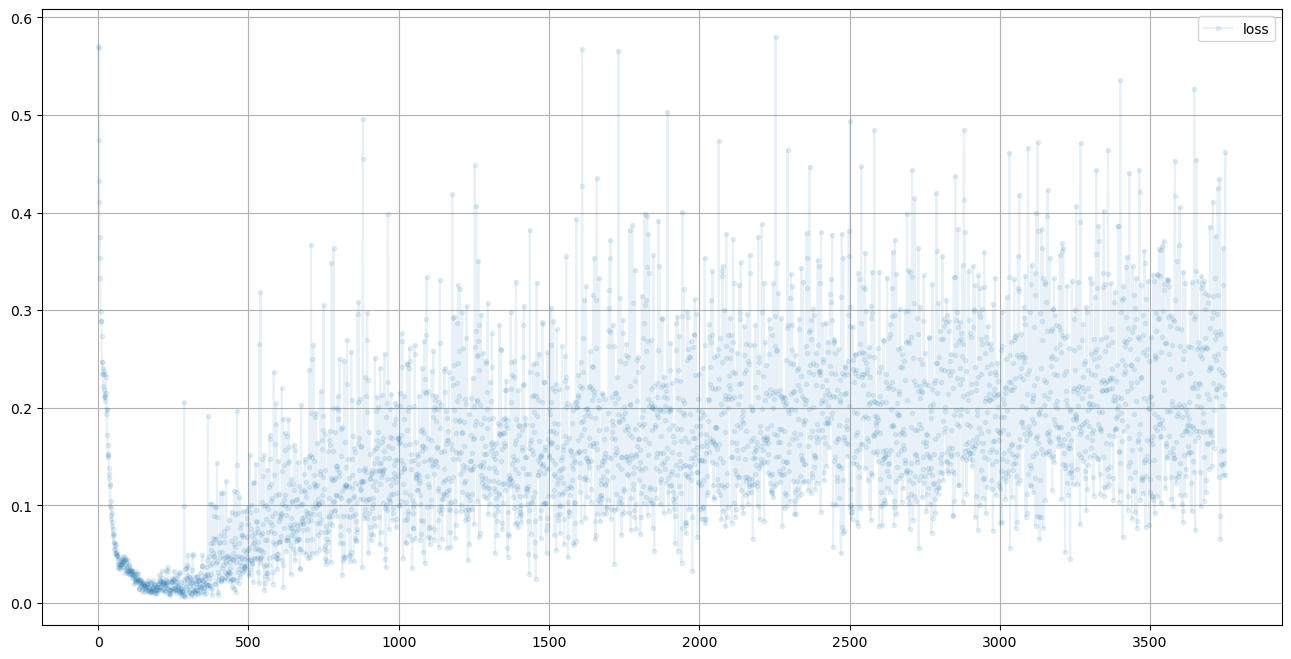

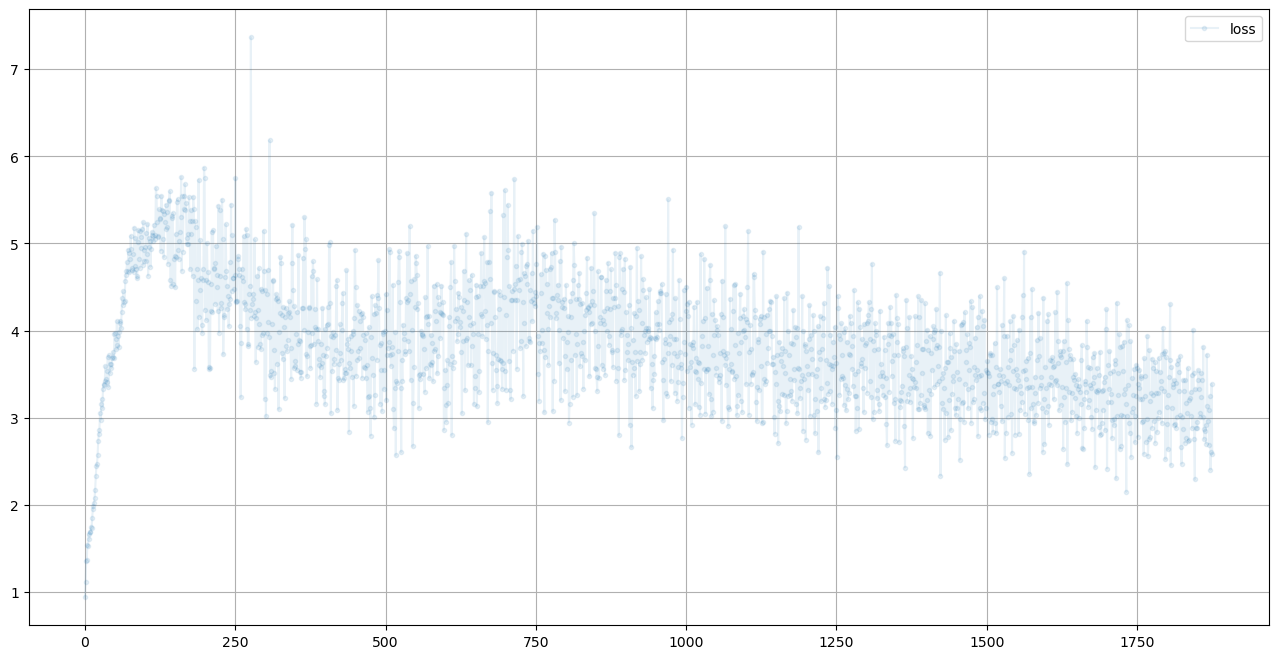

In [20]:
d.plot_progress()
g.plot_progress()

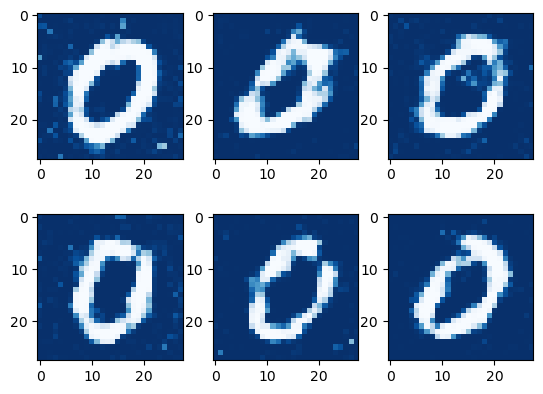

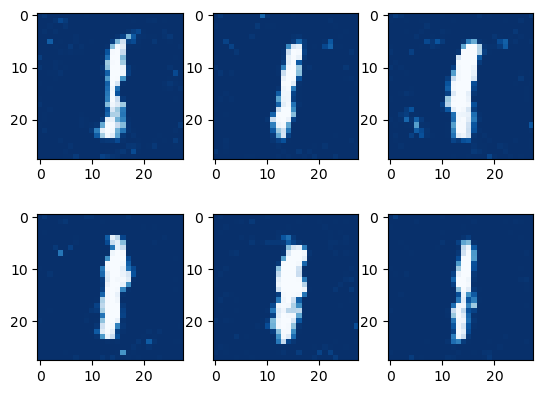

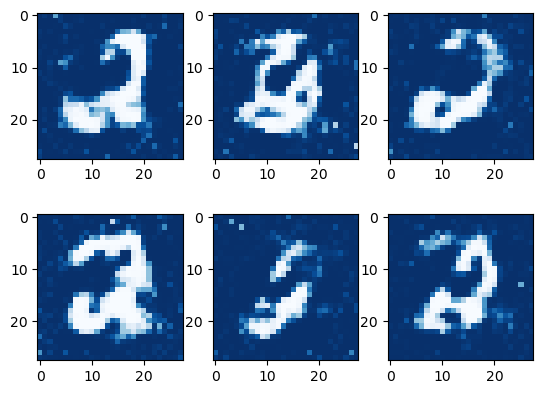

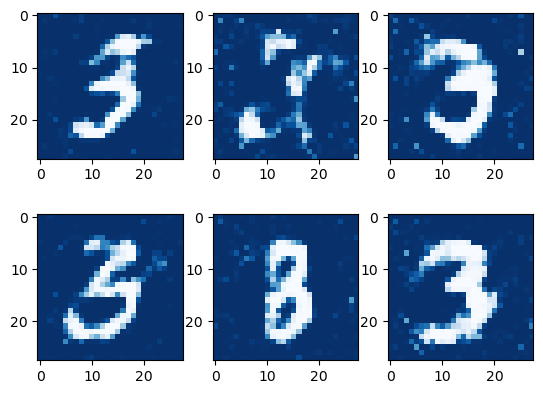

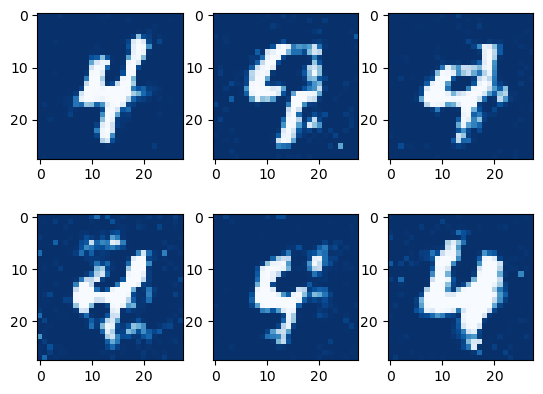

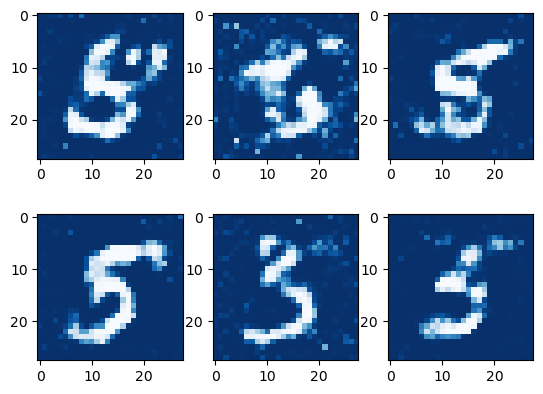

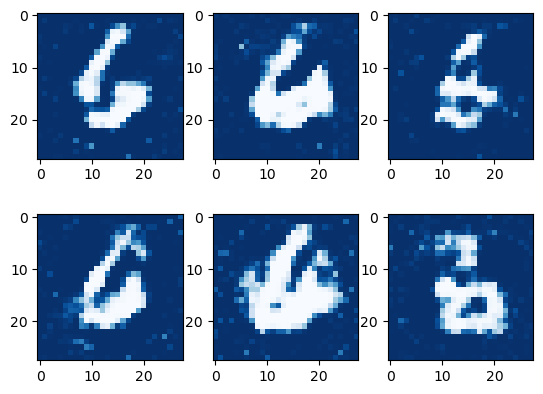

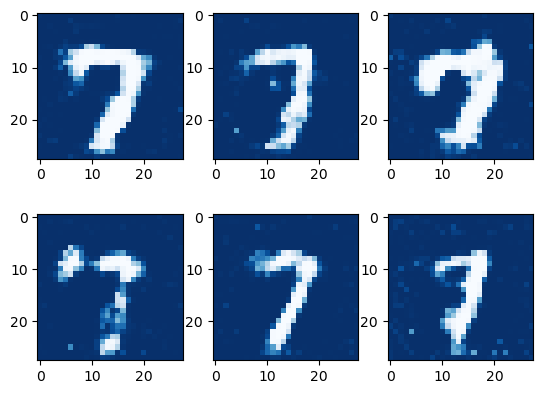

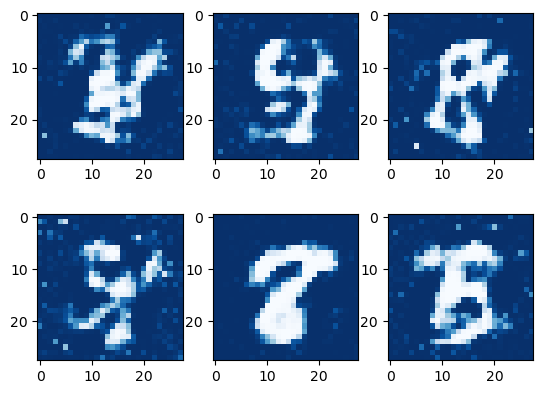

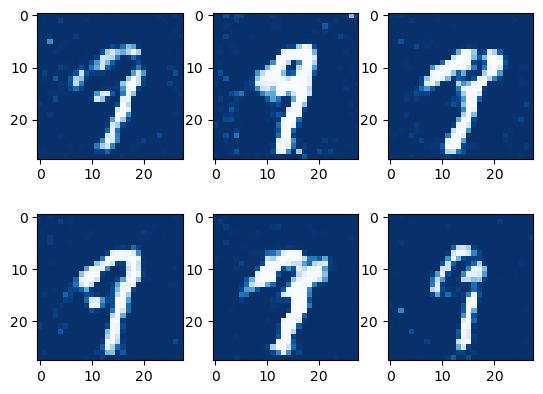

In [22]:
for n in range(10):
    g.plot_images(to_hot(torch.tensor([n])))